This notebook test the effect of multivariate noise normalization on the stability of neural RDM. 
Multivariate Noise Normalisation


Stability of neural RDM is computed using two metrics:
1) split-half correlation
2) stimuli-stimuli stability

In [132]:
import itertools
import matlab.engine
import plotly.express as px

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'src'))
from multivariate.dataloader import ActivityPatternDataLoader
from multivariate.helper import compute_rdm, checkdir, scale_feature,lower_tri,upper_tri
from multivariate.modelrdms import ModelRDM
from multivariate.rsa_searchlight import RSASearchLight
from multivariate.rsa_estimator import PatternCorrelation,MultipleRDMRegression,NeuralDirectionCosineSimilarity
from multivariate.rsa_runner import RSARunner

from sklearn.manifold import MDS,TSNE
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
import scipy
import sklearn

In [2]:
# Directories
study_scripts = os.path.join(project_path,'scripts','Exp1_fmri')
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nonlearners = pirate_defaults['participants']['nonlearnerids']
    nongeneralizers = pirate_defaults['participants']['nongeneralizerids'] + ['sub017']
    
ROIRSA_output_path = os.path.join(fmridata_dir,'ROIRSA','mvnn_effect')
checkdir(ROIRSA_output_path)

preprocess = ["unsmoothedLSA","smoothed5mmLSA"]            
n_sess = {
          "fourruns":4,
         }    

In [3]:
fmridata_dir

'E:\\pirate_fmri\\Analysis\\data\\Exp1_fmri\\fmri'

In [4]:
# ROI
maskdir = os.path.join(fmridata_dir,'masks','anat')
#with open(os.path.join(project_path,'src','anatomical_masks.json')) as f:    
#   anat_roi = list(json.load(f).keys())
laterality = ["left","right","bilateral"]
#laterality = ["bilateral"]
roi_dict = dict(zip(
    ["frontal","ofc","hippocampus","parahippocampus","parietal","occipital"],
    ["frontal","ofc","hippocampus","parahippocampus","parietal","occipital"]
    ))

In [5]:
roi_fn = "hippocampus"
lat = "right"
RSA = RSARunner(participants=subid_list,
                fmribeh_dir=fmribeh_dir,
                nsession=4,
                ## directories
                beta_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation')], beta_fname=['stimuli_4r.nii'],
                vsmask_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation'),
                            os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation'),
                            os.path.join(fmridata_dir,'unsmoothedLSA','reliability_noconcat')], 
                vsmask_fname=['mask.nii']*2 + ['reliability_mask.nii'],
                pmask_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation')], pmask_fname=['mask.nii'],
                anatmasks=[os.path.join(maskdir,f'{roi_fn}_{lat}.nii')],

                res_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation')]*4,  
                res_fname=[f'resid_run{j+1}.nii.gz' for j in range(4)],
                # configurations
                taskname="navigation",
                config_modelrdm={"randomseed":None,"nan_identity":True,"splitgroup":False},
                config_neuralrdm={"preproc":"MVNN_OAS","distance_metric":"correlation"}
                 )


In [134]:
def split_half_stability(X):
    assert X.shape[0]==100
    sess_idx = np.floor(np.arange(100)/25)
    X_odd = np.mean([X[sess_idx==0,:],X[sess_idx==2,:]],axis=0)
    X_even = np.mean([X[sess_idx==1,:],X[sess_idx==3,:]],axis=0)
    rdm_odd = compute_rdm(X_odd,"correlation")
    rdm_even = compute_rdm(X_even,"correlation")
    result = scipy.stats.pearsonr(lower_tri(rdm_odd)[0],lower_tri(rdm_even)[0])
    return result.statistic

def split_half_discriminability(X):
    assert X.shape[0]==100
    sess_idx = np.floor(np.arange(100)/25)
    X_odd = np.mean([X[sess_idx==0,:],X[sess_idx==2,:]],axis=0)
    X_even = np.mean([X[sess_idx==1,:],X[sess_idx==3,:]],axis=0)
    cross_rsm = 1-scipy.spatial.distance.cdist(X_odd,X_even,"correlation")
    on_d_mean = np.diag(cross_rsm).mean()
    off_d_mean = np.concatenate([lower_tri(cross_rsm)[0],upper_tri(cross_rsm)[0]]).mean()
    return on_d_mean-off_d_mean,cross_rsm


In [ ]:

roi_Xs = dict()
roi_Xmvnns = dict()
with Parallel(n_jobs=10) as parallel:
    for roi_fn in roi_dict.values():
        for lat in laterality:
            RSA = RSARunner(participants=subid_list,
                            fmribeh_dir=fmribeh_dir,
                            nsession=4,
                            ## directories
                            beta_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation')], beta_fname=['stimuli_4r.nii'],
                            vsmask_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation'),
                                        os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation'),
                                        os.path.join(fmridata_dir,'unsmoothedLSA','reliability_noconcat')], 
                            vsmask_fname=['mask.nii']*2 + ['reliability_mask.nii'],
                            pmask_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation')], pmask_fname=['mask.nii'],
                            anatmasks=[os.path.join(maskdir,f'{roi_fn}_{lat}.nii')],

                            res_dir=[os.path.join(fmridata_dir,"unsmoothedLSA",'LSA_stimuli_navigation')]*4,  
                            res_fname=[f'resid_run{j+1}.nii.gz' for j in range(4)],
                            # configurations
                            taskname="navigation",
                            config_modelrdm={"randomseed":None,"nan_identity":True,"splitgroup":False},
                            config_neuralrdm={"preproc":"MVNN_OAS","distance_metric":"correlation"}
                            )

            outputs_list = parallel(
                delayed(RSA.get_neuralRDM)(subid=subid) for subid in subid_list)
            X_mvnn_list = []
            X_list = []
            for jsub,(output,subid) in enumerate(zip(outputs_list,subid_list)):
                X_mvnn,_,X = output
                X_mvnn_list.append(X_mvnn)
                X_list.append(X)
            roi_Xs[f"{roi_fn}-{lat}"] = X_list
            roi_Xmvnns[f"{roi_fn}-{lat}"] = X_mvnn_list


## split half stability

In [156]:
roi_fn, lat = "frontal","bilateral"
subid = "sub006"
jsub = subid_list.index(subid)
print(f"{roi_fn}-{lat}")
print(f"raw-{subid}")
X = roi_Xmvnns[f"{roi_fn}-{lat}"][jsub]
ssX = split_half_stability(X)

frontal-bilateral
raw-sub006


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)


In [157]:
X

array([[ 0.65444476+0.00000000e+00j, -0.85752462-3.02298619e-18j,
        -0.95647195+4.22455127e-18j, ..., -0.47841033+8.65122454e-18j,
        -0.35172464-8.20387407e-18j, -0.58203732+1.11787286e-17j],
       [ 0.5297807 +0.00000000e+00j, -0.1242223 -1.58782294e-18j,
        -0.32001597+1.67573088e-18j, ..., -0.25082292+1.01335103e-17j,
         0.29314922-4.44417582e-17j,  0.22494514-2.13610376e-17j],
       [-0.03230039+0.00000000e+00j, -0.58426293+6.70992736e-19j,
         0.2206523 +2.20087508e-18j, ..., -0.52868285+2.21237168e-17j,
         0.41911033-1.99177055e-17j, -0.88348298-8.35649110e-17j],
       ...,
       [-0.04379824+6.60746692e-18j, -0.10072531+3.97309086e-18j,
         0.02684623+1.12008195e-18j, ..., -0.44510479+1.38543227e-17j,
         0.21167085+6.95472834e-17j,  0.01431665-5.82173832e-17j],
       [ 0.68339055+1.33610846e-17j, -1.13616971+9.79596959e-19j,
        -0.60348792-3.67389857e-19j, ...,  0.31738019+2.05228601e-18j,
        -0.82634697+4.46747078e-17j

In [155]:
roi_splithalf_stability_dfs = []
for roi_fn in roi_dict.values():
    for lat in laterality:
        print(f"{roi_fn}-{lat}")
        X_list = roi_Xs[f"{roi_fn}-{lat}"]
        X_mvnn_list = roi_Xmvnns[f"{roi_fn}-{lat}"]
        for jsub,(X_mvnn,X,subid) in list(enumerate(zip(X_mvnn_list,X_list,subid_list)))[:8]:
            print(f"raw-{subid}")
            ssX = split_half_stability(X)
            print(f"mvn-{subid}")
            ssXmvnn = split_half_stability(X_mvnn)
            subdf = pd.DataFrame([[ssX,ssXmvnn]],index=[jsub],columns=["raw","mvnn"]).assign(subid=subid,roi=roi_fn,laterality=lat)
            roi_splithalf_stability_dfs.append(subdf)

frontal-bilateral
raw-sub001
mvn-sub001
raw-sub002
mvn-sub002
raw-sub003
mvn-sub003
raw-sub004
mvn-sub004
raw-sub005
mvn-sub005
raw-sub006
mvn-sub006


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting 

raw-sub007
mvn-sub007
raw-sub008
mvn-sub008
ofc-bilateral
raw-sub001
mvn-sub001
raw-sub002
mvn-sub002
raw-sub003
mvn-sub003
raw-sub004
mvn-sub004
raw-sub005
mvn-sub005
raw-sub006
mvn-sub006
raw-sub007
mvn-sub007
raw-sub008
mvn-sub008
hippocampus-bilateral
raw-sub001
mvn-sub001
raw-sub002
mvn-sub002
raw-sub003
mvn-sub003
raw-sub004
mvn-sub004
raw-sub005
mvn-sub005
raw-sub006
mvn-sub006
raw-sub007
mvn-sub007
raw-sub008
mvn-sub008
parahippocampus-bilateral
raw-sub001
mvn-sub001
raw-sub002
mvn-sub002
raw-sub003
mvn-sub003
raw-sub004
mvn-sub004
raw-sub005
mvn-sub005
raw-sub006
mvn-sub006
raw-sub007
mvn-sub007
raw-sub008
mvn-sub008
parietal-bilateral
raw-sub001
mvn-sub001
raw-sub002
mvn-sub002
raw-sub003
mvn-sub003
raw-sub004
mvn-sub004
raw-sub005
mvn-sub005
raw-sub006
mvn-sub006
raw-sub007
mvn-sub007
raw-sub008
mvn-sub008
occipital-bilateral
raw-sub001
mvn-sub001
raw-sub002
mvn-sub002
raw-sub003
mvn-sub003
raw-sub004
mvn-sub004
raw-sub005
mvn-sub005
raw-sub006
mvn-sub006
raw-sub007
mvn-sub0

c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting 

In [116]:
roi_splithalf_stability_df = pd.concat(roi_splithalf_stability_dfs).reset_index(drop=True)
roi_splithalf_stability_df["subgroup"] = ["nonGeneralizers" if subid in nongeneralizers else "Generalizers" for subid in roi_splithalf_stability_df["subid"]]
roi_splithalf_stability_df["change_type"] = ["decreased" if r>m else "increased" for r,m in zip(roi_splithalf_stability_df["raw"],roi_splithalf_stability_df["mvnn"])]
roi_splithalf_stability_df["change_type"] = [s if np.max(np.abs([r,m]))>0.4 else ct for r,m,s,ct in zip(roi_splithalf_stability_df["raw"],roi_splithalf_stability_df["mvnn"],roi_splithalf_stability_df["subid"],roi_splithalf_stability_df["change_type"])]
print(np.unique(roi_splithalf_stability_df["change_type"]))
roi_splithalf_stability_df.head(5)
n_line_color = np.unique(roi_splithalf_stability_df["change_type"]).size+1
sns.color_palette(None,n_line_color)

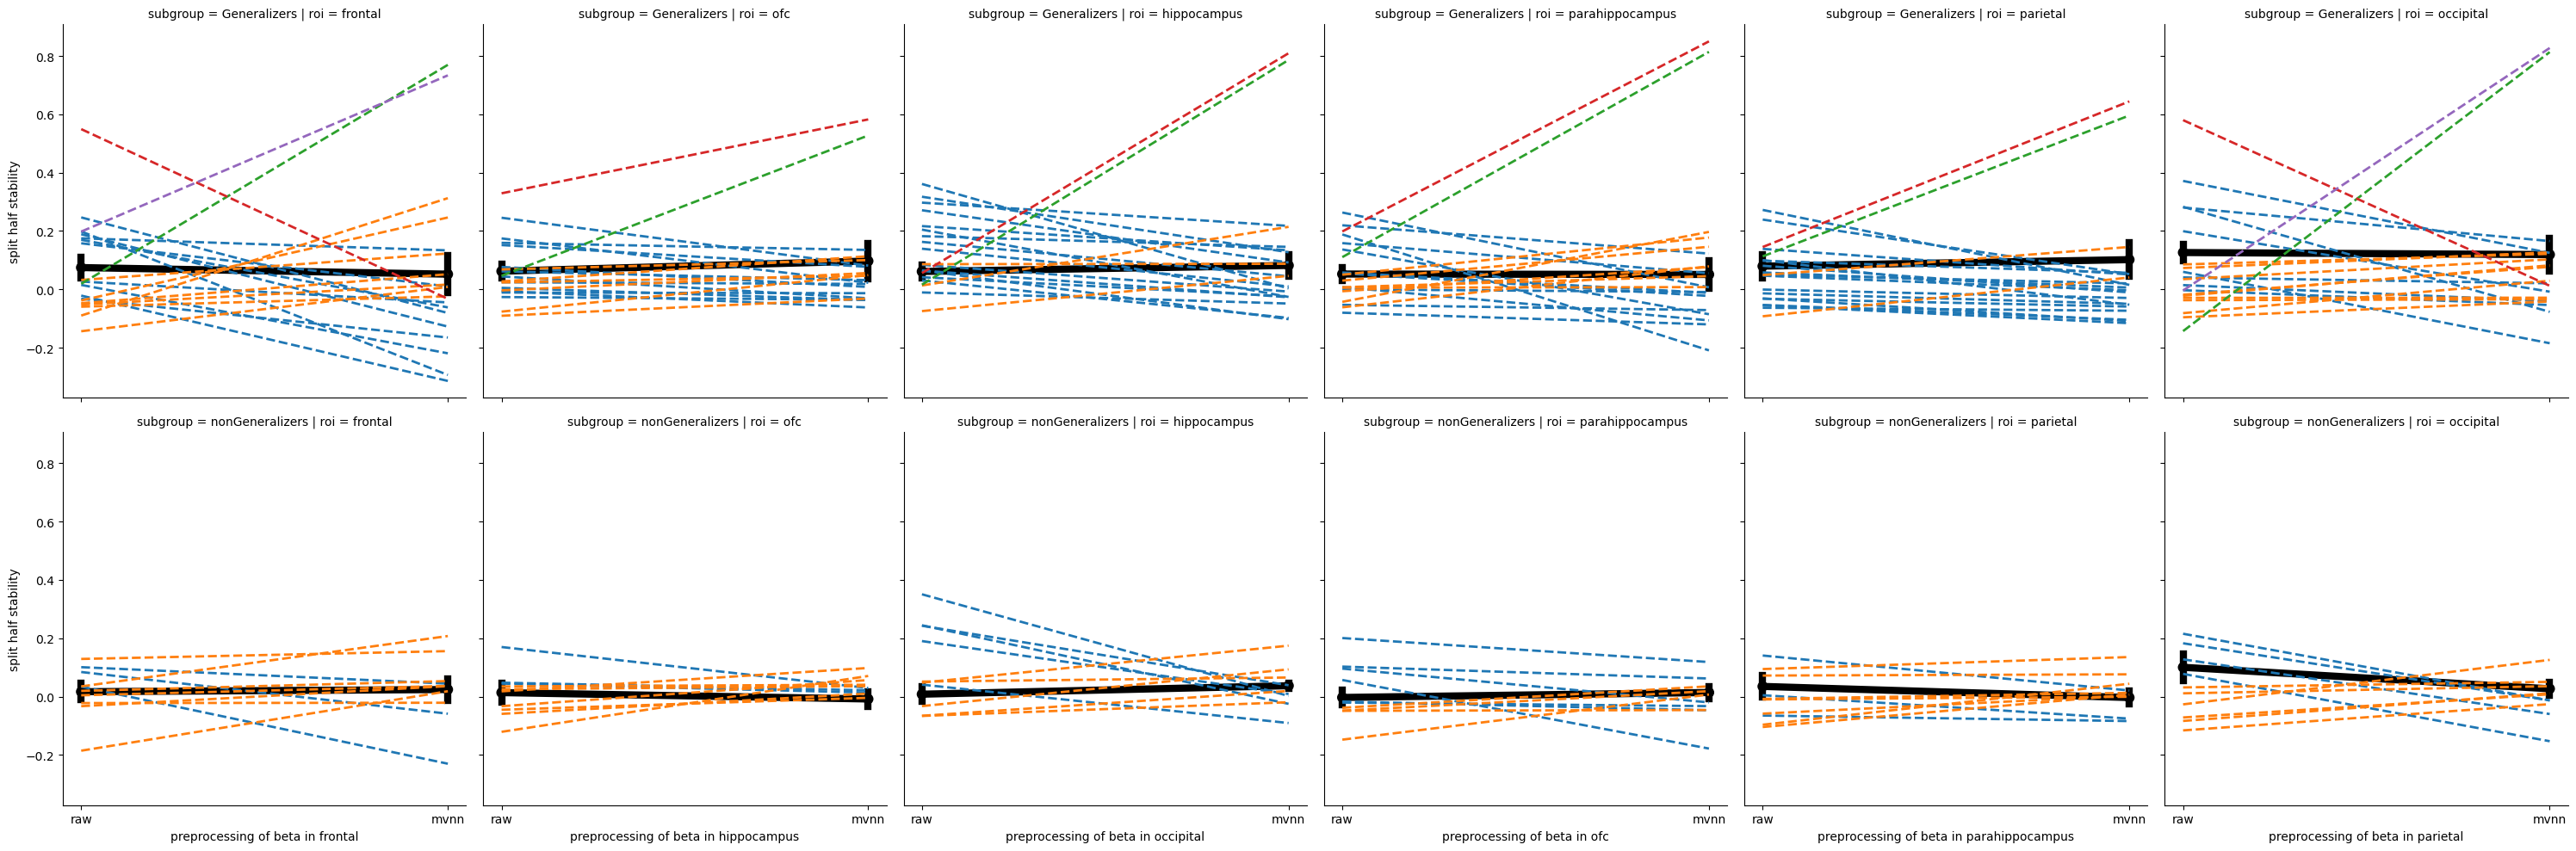

In [127]:
roi_splithalf_stability_df_long = pd.melt(roi_splithalf_stability_df,id_vars=["subid","change_type","subgroup","roi","laterality"],value_vars=["mvnn","raw"],value_name="split half stability", var_name="preprocessing of beta")
roi_splithalf_stability_df_long['preprocessing of beta'] = pd.Categorical(roi_splithalf_stability_df_long['preprocessing of beta'],
                                   categories=['raw', 'mvnn'],
                                   ordered=True)

n_line_color = np.unique(roi_splithalf_stability_df["change_type"]).size
line_colors = sns.color_palette(None,n_line_color)
split_half_gs = sns.catplot(data=roi_splithalf_stability_df_long,
            x="preprocessing of beta",y="split half stability",
            col="roi",
            row="subgroup",
            units="subid",errorbar="se",
            kind="point",
            color="black"
            )
for (roi_fn,roi_df),ax in zip(roi_splithalf_stability_df_long.groupby(["subgroup","roi"]),split_half_gs.axes.flatten()):
    ax.set_xlabel(f"{ax.get_xlabel()} in {roi_fn[1]}") 
    plt.setp(ax.lines,linewidth=6)
    for kcolor,(_,ct_df) in enumerate(roi_df.groupby(["change_type"])):
        line_color = line_colors[kcolor]
        for jsub,(subid,subdf) in enumerate(ct_df.groupby(["subid"])):
            sns.lineplot(subdf,x="preprocessing of beta",y="split half stability",
                        **{"color":line_color,"linestyle":"--","linewidth":2},
                        ax=ax)


## split half discriminability

In [139]:
roi_splithalf_discriminability_dfs = []
for roi_fn in roi_dict.values():
    for lat in laterality:
        X_list = roi_Xs[f"{roi_fn}-{lat}"]
        X_mvnn_list = roi_Xmvnns[f"{roi_fn}-{lat}"]
        for jsub,(X_mvnn,X,subid) in enumerate(zip(X_mvnn_list,X_list,subid_list)):
            split_half_discriminability(X)[0]
            subdf = pd.DataFrame([[split_half_discriminability(X)[0],split_half_discriminability(X_mvnn)[0]]],
                                 index=[jsub],columns=["raw","mvnn"]).assign(subid=subid,roi=roi_fn,laterality=lat)
            roi_splithalf_discriminability_dfs.append(subdf)


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\spatial\distance.py:147: ComplexWarning: Casting 

In [120]:
roi_splithalf_stability_df = pd.concat(roi_splithalf_stability_dfs).reset_index(drop=True)
roi_splithalf_stability_df["subgroup"] = ["nonGeneralizers" if subid in nongeneralizers else "Generalizers" for subid in roi_splithalf_stability_df["subid"]]
roi_splithalf_stability_df["change_type"] = ["decreased" if r>m else "increased" for r,m in zip(roi_splithalf_stability_df["raw"],roi_splithalf_stability_df["mvnn"])]
roi_splithalf_stability_df["change_type"] = [s if np.max(np.abs([r,m]))>0.4 else ct for r,m,s,ct in zip(roi_splithalf_stability_df["raw"],roi_splithalf_stability_df["mvnn"],roi_splithalf_stability_df["subid"],roi_splithalf_stability_df["change_type"])]
print(np.unique(roi_splithalf_stability_df["change_type"]))
roi_splithalf_stability_df.head(5)
n_line_color = np.unique(roi_splithalf_stability_df["change_type"]).size+1
sns.color_palette(None,n_line_color)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

###### single participant

In [26]:
X_mvnn,_,X = RSA.get_neuralRDM(subid=subid_list[0])
[split_half_stability(X),split_half_stability(X_mvnn)]
with Parallel(n_jobs=10) as parallel:
    outputs_list = parallel(
        delayed(RSA.get_neuralRDM)(subid=subid) for subid in subid_list)


In [30]:
splithalf_stability_dfs = []
X_mvnn_list = []
X_list = []
for jsub,(output,subid) in enumerate(zip(outputs_list,subid_list)):
    X_mvnn,_,X = output
    X_mvnn_list.append(X_mvnn)
    X_list.append(X)
    subdf = pd.DataFrame([[split_half_stability(X),split_half_stability(X_mvnn)]],index=[jsub],columns=["mvnn","raw"]).assign(subid=subid)
    splithalf_stability_dfs.append(subdf)

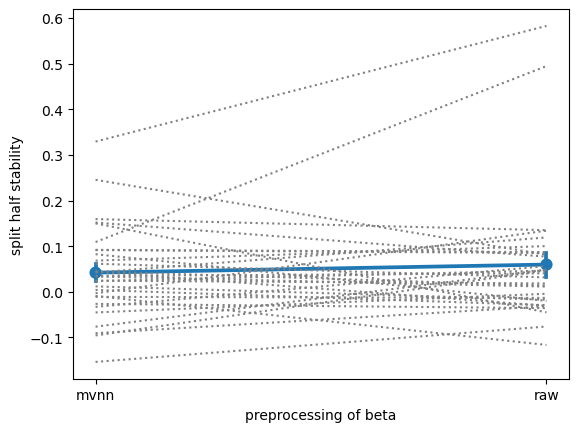

In [45]:
splithalf_stability_df = pd.concat(splithalf_stability_dfs).reset_index(drop=True)
splithalf_stability_df.head(5)
splithalf_stability_df_long = pd.melt(splithalf_stability_df,id_vars="subid",value_vars=["mvnn","raw"],value_name="split half stability", var_name="preprocessing of beta")
split_half_ax = sns.pointplot(data=splithalf_stability_df_long,
            x="preprocessing of beta",y="split half stability",
            units="subid",errorbar="se"
            )
for subid,subdf in splithalf_stability_df_long.groupby(["subid"]):
    sns.lineplot(subdf,x="preprocessing of beta",y="split half stability",**{"color":"grey","linestyle":":"})

<Axes: >

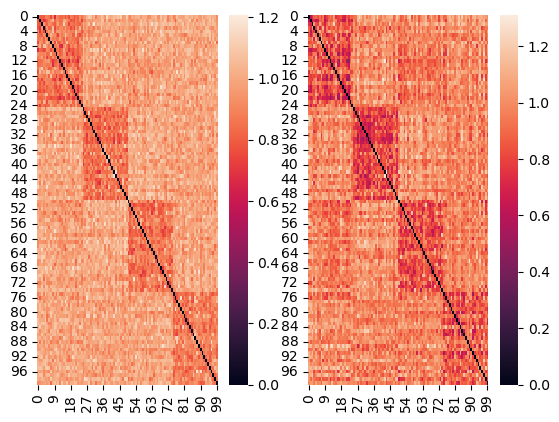

In [8]:
X_mvnn

rdm_mvnn = compute_rdm(X_mvnn,"correlation")
rdm = compute_rdm(X,"correlation")
fig,axes = plt.subplots(1,2)
sns.heatmap(rdm_mvnn,ax=axes[0])
sns.heatmap(rdm,ax=axes[1])